# Bedrock Inline Agent Chat Model with LangGraph

This notebook demonstrates how to use BedrockInlineAgentsRunnable with LangGraph for a mortgage rate assistant that maintains chat history and context.

### Prerequisites:
1. AWS credentials configured
2. langchain, langgraph, and boto3 packages installed
3. langchain-aws package accessible

### Step 1: Define the tools for the agent

In [ ]:
from langchain_core.tools import tool


@tool("AssetDetail::getAssetValue")
def get_asset_value(asset_holder_id: str) -> str:
    """
    Get the asset value for an owner id

    Args:
        asset_holder_id: The asset holder id

    Returns:
        The asset value for the given asset holder
    """
    return f"The total asset value for {asset_holder_id} is 100K"


@tool("AssetDetail::getMortgageRate")
def get_mortgage_rate(asset_holder_id: str, asset_value: str) -> str:
    """
    Get the mortgage rate based on asset value

    Args:
        asset_holder_id: The asset holder id
        asset_value: The value of the asset

    Returns:
        The interest rate for the asset holder and asset value
    """
    return f"The mortgage rate for {asset_holder_id} with asset value of {asset_value} is 8.87%"


tools = [get_asset_value, get_mortgage_rate]
tool_map = {tool.name: tool for tool in tools}

### Step 2: Create the BedrockInlineAgentsRunnable

In [ ]:
from langchain_aws.agents import BedrockInlineAgentsRunnable

foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"
instructions = "You are an agent who helps with getting the mortgage rate based on the current asset valuation"

inline_agent_config = {
    "foundation_model": foundation_model,
    "instruction": instructions,
    "tools": tools,
    "enable_trace": False,
}

inline_agent = BedrockInlineAgentsRunnable.create(
    region_name="us-west-2", inline_agent_config=inline_agent_config
)

### Step 3: Define the State for your Graph

In [ ]:
from typing import TypedDict, List, Optional
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    SystemMessage,
    ToolMessage,
)


class ChatState(TypedDict):
    """Defines the state for the Chat Graph"""

    messages: List[BaseMessage]
    """Chat message history"""
    current_message: str
    """Current input message"""
    session_id: Optional[str]
    """Session ID for conversation tracking"""
    tool_response: Optional[str]
    """Response from tool execution"""
    step_count: int
    """Step count for internal tracking"""

### Step 4: Define the nodes for your LangGraph

In [ ]:
def execute_tools(state: ChatState) -> ChatState:
    last_message = state["messages"][-1]

    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        tool_call = last_message.tool_calls[0]
        tool_name = tool_call["name"]
        tool = tool_map.get(tool_name)

        if tool:
            try:
                # Execute the function
                tool_fn = tool.func
                tool_response = tool_fn(**tool_call["args"])

                # Format the response in the expected session state format
                action_group_name, function_name = (
                    tool_name.split("::")
                    if "::" in tool_name
                    else ("Default", tool_name)
                )
                print(
                    f"Creating tool message for Action Group: {action_group_name} and function: {function_name}"
                )
                tool_message = ToolMessage(
                    tool_response, tool_call_id=tool_call["id"], name=function_name
                )
                state["messages"] = state["messages"] + [tool_message]

            except Exception as e:
                print(f"Debug - Tool execution error: {str(e)}")
                state["tool_response"] = None

    state["step_count"] = state.get("step_count", 0) + 1
    return state


def run_chat(state: ChatState) -> ChatState:
    messages = state["messages"]
    last_message = messages[-1]
    # If there's a tool response, we need to configure the chat model with the session state
    if isinstance(last_message, ToolMessage):
        # Update the chat model's configuration with the session state
        inline_agent.inline_agent_config = {**inline_agent_config}
        state["tool_response"] = None  # Clear the tool response
    else:
        # Reset the chat model's configuration to default to remove roc details
        inline_agent.inline_agent_config = inline_agent_config
        # If no tool response, this is a new message
        messages.append(HumanMessage(content=state["current_message"]))

    # Get response from the model
    response = inline_agent.invoke(messages)

    # Update state
    state["messages"] = messages + [response]
    state["step_count"] = state.get("step_count", 0) + 1

    if "session_id" in response.additional_kwargs:
        state["session_id"] = response.additional_kwargs["session_id"]

    return state

### Step 5: Define the conditional function for workflow control

In [ ]:
def should_continue(state: ChatState) -> str:
    last_message = state["messages"][-1]

    # If there's a tool response, always continue to process it
    if state["tool_response"] is not None:
        return "continue"

    # If there are tool calls, continue
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "continue"

    # End if no more actions needed
    return "end"

### Step 6: Build and compile the graph

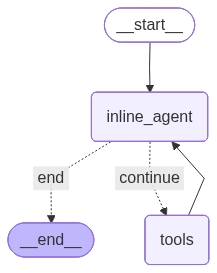

In [ ]:
from langgraph.graph import END, StateGraph, START

# Create the workflow
workflow = StateGraph(ChatState)

# Add nodes
workflow.add_node("inline_agent", run_chat)
workflow.add_node("tools", execute_tools)

# Set the entrypoint
workflow.add_edge(START, "inline_agent")

# Add conditional edges
workflow.add_conditional_edges(
    "inline_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

# Complete the loop
workflow.add_edge("tools", "inline_agent")

# Compile the graph
app = workflow.compile()
app

### Step 7: Test the chat workflow

In [ ]:
# Initialize with system message
initial_state = {
    "messages": [SystemMessage(content=instructions)],
    "current_message": "What is my mortgage rate for id AVC-1234?",
    "session_id": None,
    "tool_response": None,
    "step_count": 0,
}

result = app.invoke(initial_state)

print("Conversation:")
for msg in result["messages"]:
    print(f"\n{msg.__class__.__name__}: {msg.content}")
    if hasattr(msg, "tool_calls") and msg.tool_calls:
        print(f"Tool Calls: {msg.tool_calls}")
    if hasattr(msg, "additional_kwargs") and msg.additional_kwargs:
        print(f"Additional Info: {msg.additional_kwargs}")

print(f"\nTotal steps: {result['step_count']}")